In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DI725/DI725-assignment2/

Mounted at /content/drive
/content/drive/MyDrive/DI725/DI725-assignment2


## Preliminaries


In [3]:
!pip install torchmetrics

In [125]:
import math
import pandas as pd
import numpy as np

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax
torch.set_grad_enabled(False);

import os
import json
from tqdm import tqdm

In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

auair_to_coco = {0: 1, 1: 3, 2: 8, 3: None, 4: 4, 5: 2, 6: 6, 7: None}
coco_to_auir = {v: k for k, v in auair_to_coco.items()}

In [6]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1).to('cuda')

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to('cuda')
    return b.to('cuda')

def auair_bbox_to_xyxy(bbox):
    x_min = bbox['left']
    y_min = bbox['top']
    x_max = x_min + bbox['width']
    y_max = y_min + bbox['height']
    return [x_min, y_min, x_max, y_max]

In [7]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [134]:
def calculate_iou(bbox1, bbox2):
    #bboxes are of form x_min, y_min, x_max, y_max
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])

    if x2 < x1 or y2 < y1:
        return 0
    intersection = (y2 - y1) * (x2 - x1)
    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    union = area1 + area2 - intersection

    iou = intersection / union
    return iou


def find_closest_bbox(bbox, bboxes):
    max_iou = 0
    closest_bbox_index = None
    for i, bbox2 in enumerate(bboxes):
        iou = calculate_iou(bbox, bbox2)
        if iou > max_iou:
            max_iou = iou
            closest_bbox_index = i
    return closest_bbox_index, max_iou



In [9]:
DATA_DIR = "auair2019data"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations.json")
IOU_THRESHOLD = 0.5

# Loading the model

In [10]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.to('cuda') if torch.cuda.is_available() else model.to('cpu')
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Importing the data

In [11]:
with open(ANNOTATIONS_FILE, 'r') as f:
    data = json.load(f)

annotations = data["annotations"]

In [132]:
test_annot = annotations

In [13]:
# Extract category information
categories = {idx: cat for idx, cat in enumerate(data['categories'], start=0)}
id2label = {k: v for k, v in categories.items()}
label2id = {v: k for k, v in id2label.items()}


In [133]:
image_paths = []
test_outputs = []
test_ground_truth_bbox = []
test_ground_truth_classes = []

for annot in tqdm(test_annot, desc="Evaluating samples"):

    image_path = f'{IMAGES_DIR}/{annot["image_name"]}'
    im = Image.open(image_path)
    image_paths.append(image_path)

    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to('cuda') if torch.cuda.is_available() else img.to('cpu')
    # propagate through the model
    outputs = model(img)

    test_outputs.append(outputs)

    ground_truth_bboxes = torch.Tensor([auair_bbox_to_xyxy(bbox) for bbox in annot['bbox']]).to('cuda')
    test_ground_truth_bbox.append(ground_truth_bboxes)

    ground_truth_classes = torch.Tensor([bbox['class'] for bbox in annot['bbox']]).to('cuda').to(torch.int64)
    test_ground_truth_classes.append(ground_truth_classes)

for output in test_outputs:

    # keep only predictions with 0.7+ confidence
    probas = output['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    output['bboxes_scaled_filtered'] = rescale_bboxes(output['pred_boxes'][0, keep], im.size)
    output['probas_filtered'] = probas[keep]

Evaluating samples: 100%|██████████| 32823/32823 [4:27:48<00:00,  2.04it/s]


In [135]:
results = pd.DataFrame(columns=['image_name', 'true_class', 'pred_class', 'iou', 'pred_confidence'])

for i in range(len(test_outputs)):
    image_path = image_paths[i]
    image_name = image_path.split('/')[-1]
    output = test_outputs[i]
    pred_probas = output['probas_filtered']
    pred_classes = [pred_probas[i].argmax() for i in range(len(pred_probas))]
    pred_bboxes = output['bboxes_scaled_filtered']
    ground_truth_bboxes = test_ground_truth_bbox[i]
    ground_truth_classes = [auair_to_coco[int(i)] for i in test_ground_truth_classes[i]]

    considered_ground_truth_indexes = []
    for j in range(len(pred_bboxes)):
        bbox = pred_bboxes[j]
        pred = pred_classes[j]
        closest_bbox_index, iou = find_closest_bbox(bbox, ground_truth_bboxes)
        considered_ground_truth_indexes.append(closest_bbox_index)
        if closest_bbox_index is None:
            result = {'image_name': image_name, 'true_class': math.nan,
                      'pred_class': int(pred),'iou': float(iou), 'pred_confidence': math.nan}
        else:
            result = {'image_name': image_name, 'true_class': ground_truth_classes[closest_bbox_index],
                  'pred_class': int(pred),'iou': float(iou), 'pred_confidence': float(pred_probas[j][pred])}

        results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)
    for i in range(len(ground_truth_bboxes)):
        if i not in considered_ground_truth_indexes:
            result = {'image_name': image_name, 'true_class': ground_truth_classes[i],
                      'pred_class': math.nan,'iou': math.nan, 'pred_confidence': math.nan}
            results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)

<ipython-input-135-861d09469dba>:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([result])], ignore_index=True)


In [129]:
results

,image_name,true_class,pred_class,iou,pred_confidence
0,frame_20190829091111_x_0001973.jpg,3,3,0.672136,0.958085
1,frame_20190829091111_x_0001973.jpg,3,3,0.809200,0.944088
2,frame_20190829091111_x_0001973.jpg,1,NaN,NaN,NaN
3,frame_20190829091111_x_0000334.jpg,NaN,62,0.000000,NaN
4,frame_20190829091111_x_0000334.jpg,3,3,0.174954,0.996698
...,...,...,...,...,...
2844,frame_20190829091111_x_0002645.jpg,3,NaN,NaN,NaN
2845,frame_20190829091111_x_0002645.jpg,1,NaN,NaN,NaN
2846,frame_20190829091111_x_0002116.jpg,3,77,0.903518,0.996727
2847,frame_20190829091111_x_0002116.jpg,1,NaN,NaN,NaN


In [136]:
from sklearn.metrics import auc, average_precision_score

def calculate_precision_recall(results, per_class = True, threshold = IOU_THRESHOLD):
    classes = results['true_class'].dropna().unique()
    TP = (results['true_class'] == results['pred_class']) & (results['iou'] >= threshold)
    FP = (results['iou'] < threshold) | (results['pred_class'] != results['true_class'])
    FN = (results['true_class'] != math.nan) & (results['pred_class'].isna())
    if per_class:
        precisions = []
        recalls = []
        for c in classes:
            tp = TP[results['true_class'] == c].sum()
            fp = FP[results['true_class'] == c].sum()
            fn = FN[results['true_class'] == c].sum()

            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            precisions.append(precision)
            recalls.append(recall)
        return precisions, recalls, classes

    else:
        tp = TP.sum()
        fp = FP.sum()
        fn = FN.sum()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        return precision, recall

def calculate_map(results, per_class = True, threshold = IOU_THRESHOLD):
    if per_class:
        precisions_list_per_class = []
        recalls_list_per_class = []
        for threshold in np.arange(threshold,1,0.05):
            precisions, recalls, classes = calculate_precision_recall(results, per_class, threshold)
            precisions_list_per_class.append(precisions)
            recalls_list_per_class.append(recalls)
        map_per_class = []
        for i in range(len(classes)):
            precisions_list = []
            recalls_list = []
            for j in range(len(precisions_list_per_class)):
                precisions_list.append(precisions_list_per_class[j][i])
                recalls_list.append(recalls_list_per_class[j][i])
            map = round(auc(recalls_list, precisions_list),3)
            map_per_class.append(map)
        return map_per_class, classes
    else:
        precisions_list = []
        recalls_list = []
        for threshold in np.arange(threshold,1,0.05):
            precision, recall = calculate_precision_recall(results, per_class, threshold)

            precisions_list.append(precision)
            recalls_list.append(recall)

        map = round(auc(recalls_list, precisions_list),3)

        return map
    classes = results['true_class'].dropna().unique()

In [137]:
calculate_map(results, per_class = True, threshold = IOU_THRESHOLD)

([np.float64(0.045),
  np.float64(0.007),
  np.float64(0.09),
  np.float64(0.001),
  np.float64(0.005),
  np.float64(0.068)],
 array([3, 1, 8, 2, 4, 6], dtype=object))

In [139]:
os.makedirs("detr_pretrained", exist_ok=True)
results.to_csv("detr_pretrained/predictions.csv")

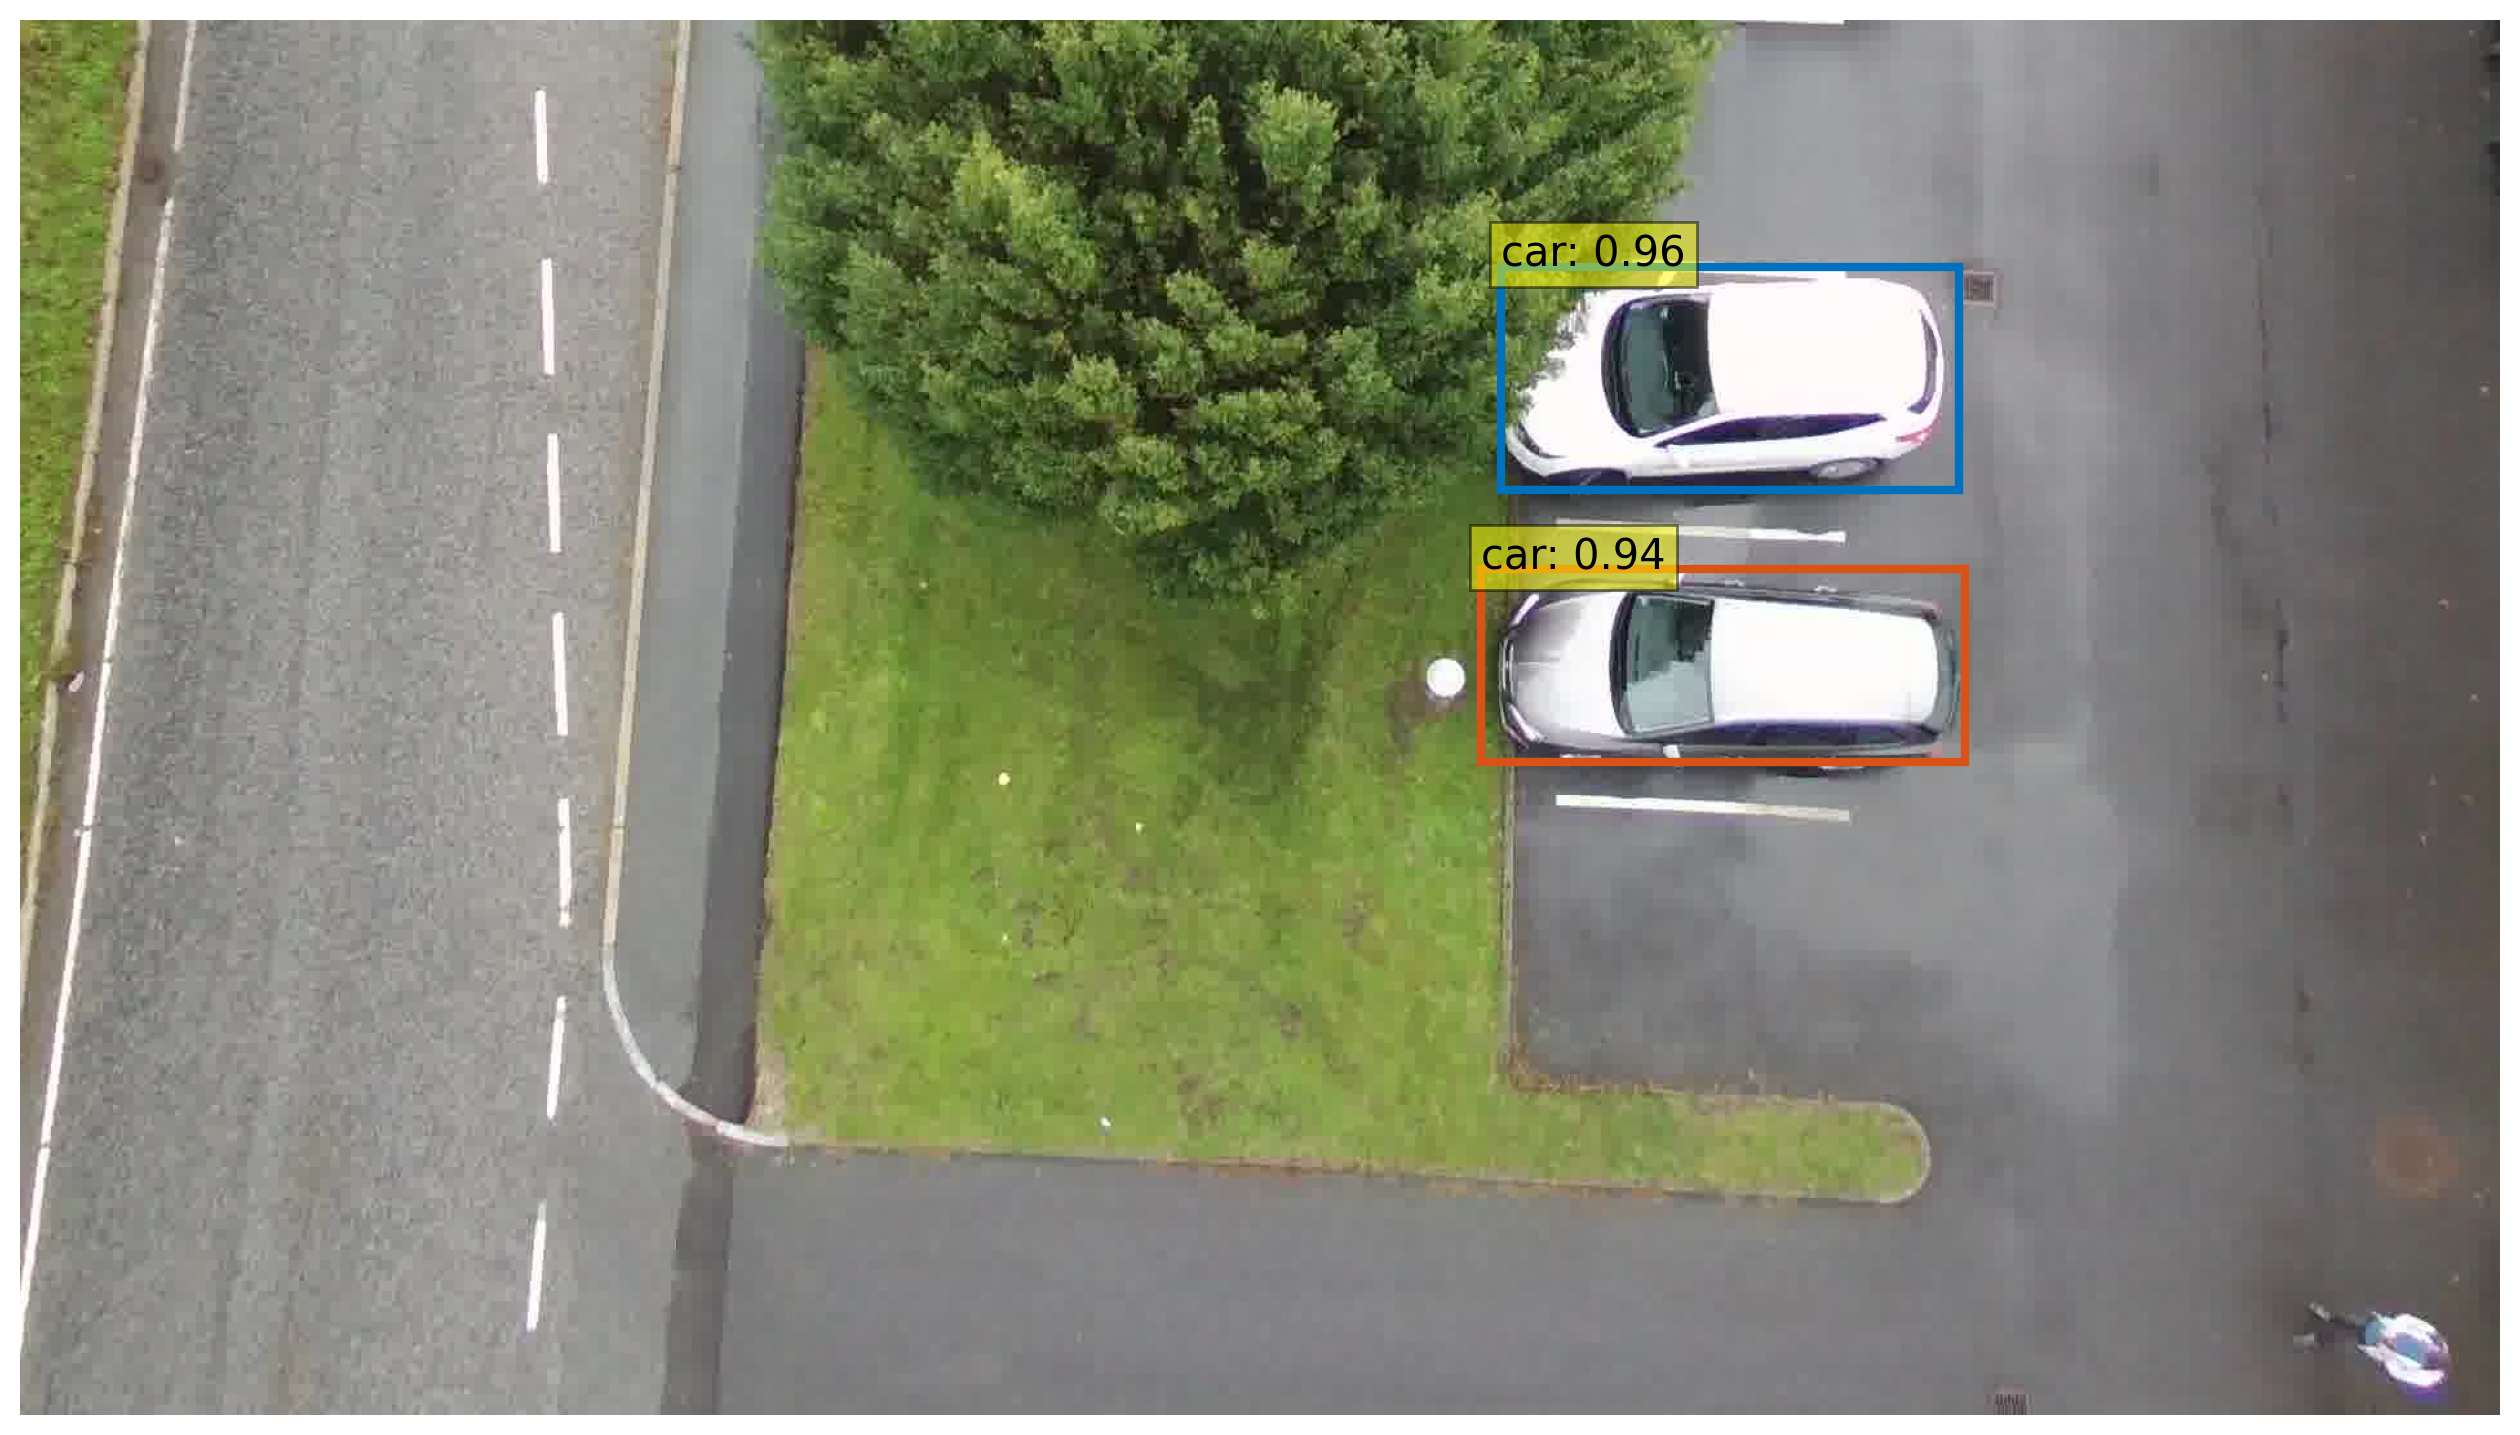

In [ ]:
image_path = image_paths[0]
im = Image.open(image_path)
plot_results(im, test_outputs[0]['probas_filtered'], test_outputs[0]['bboxes_scaled_filtered'])